In [24]:
from torch.utils.data import Dataset
import torch
import glob
import torchaudio
import pandas as pd
from datetime import datetime
import os

import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
from scipy import signal

class SHMDataset(Dataset):
  def __init__(self):
      self.sensors = ['C1.1.1'] #['C1.1.1', 'C16.1.3', 'C4.2.3']
      self.start_time, self.end_time = "05/12/2021 23:54", "05/12/2021 23:55"
      self.path = "./traffic/"
      self.data = self._readCSV()
      self.sampleRate = 100
      self.frameLength = 5 #in seconds
      self.stepLength = 1 #in seconds

  def __len__(self):
      # TODO: define how to count the len of the dataset
      return int((len(self.data)-(self.frameLength*self.sampleRate))/(self.stepLength*self.sampleRate))

  def __getitem__(self, index):
      signal = self.data[index*self.stepLength*self.sampleRate:(index*self.stepLength + self.frameLength)*self.sampleRate]
      signal = self._transformation(signal)
      return signal

  def _readCSV(self):
      start = datetime.strptime(self.start_time, '%d/%m/%Y %H:%M')
      end = datetime.strptime(self.end_time, '%d/%m/%Y %H:%M')

      ldf = list()
      for p in glob.glob(self.path + "*.csv"):
          name = os.path.split(p)[-1]
          nstr = datetime.strptime(name, 'traffic_%Y%m%dH%H%M%S.csv')
          if start <= nstr < end:
              df_tmp = pd.read_csv(p)
              c_drop = set(df_tmp.columns) - set(["sens_pos", "z", "ts"])
              if len(c_drop) > 0:
                  df_tmp.drop(columns=list(c_drop), inplace=True)
              ldf.append(df_tmp)
      df = pd.concat(ldf).sort_values(by=['sens_pos', 'ts'])
      df.reset_index(inplace=True, drop=True)

      df = df[df['sens_pos'].isin(self.sensors)]
      df['ts'] = pd.to_datetime(df['ts'], unit='ms')

      return np.array(df['z'])

  def _transformation(self, signal):
      stft = torchaudio.transforms.Spectrogram(win_length=100, hop_length=10)
      signal = stft(torch.tensor(signal))
      #signal = torch.square(torch.abs(signal)**2)
      #powerToDB = torchaudio.transforms.AmplitudeToDB(stype='power')
      #signal = powerToDB(signal)

      return signal

In [2]:
gen = SHMDataset()

In [11]:
def printSpect(gen, index):
    df = gen[index]

    plt.figure(figsize=(10, 5))
    librosa.display.specshow(df.numpy())
    plt.colorbar()

In [ ]:
for i in range(100):
  printSpect(gen, i)

with Librosa

In [27]:
sensors = ['C1.1.1'] #['C1.1.1', 'C16.1.3', 'C4.2.3']
start_time, end_time = "05/12/2021 23:54", "05/12/2021 23:55"
path = "./traffic/"

start = datetime.strptime(start_time, '%d/%m/%Y %H:%M')
end = datetime.strptime(end_time, '%d/%m/%Y %H:%M')

ldf = list()
for p in glob.glob(path + "*.csv"):
    name = os.path.split(p)[-1]
    nstr = datetime.strptime(name, 'traffic_%Y%m%dH%H%M%S.csv')
    if start <= nstr < end:
        df_tmp = pd.read_csv(p)
        c_drop = set(df_tmp.columns) - set(["sens_pos", "z", "ts"])
        if len(c_drop) > 0:
            df_tmp.drop(columns=list(c_drop), inplace=True)
        ldf.append(df_tmp)
df = pd.concat(ldf).sort_values(by=['sens_pos', 'ts'])
df.reset_index(inplace=True, drop=True)

df = df[df['sens_pos'].isin(sensors)]
df['ts'] = pd.to_datetime(df['ts'], unit='ms')
signald = np.array(df['z'])

In [3]:
def getChunk(data, index):
  frameLength = 5 #in seconds
  stepLength = 1 #in seconds
  sampleRate = 100
  window = data[index*stepLength*sampleRate:(index*stepLength + frameLength)*sampleRate]
  return window

In [17]:
def plotSpectrogram(signal, sr, hop_length, y_axis='linear'):
  plt.figure(figsize=(10, 5))
  librosa.display.specshow(signal,
                           sr=sr,
                           hop_length=hop_length,
                           x_axis="time",
                           y_axis=y_axis)
  plt.colorbar(format="%+2.f", label='db')

In [28]:
signald.shape

(6000,)

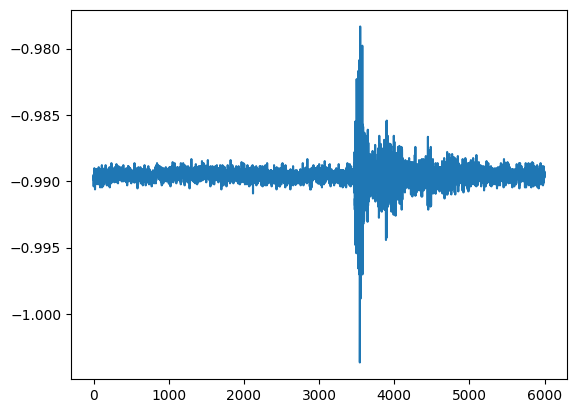

In [29]:
plt.plot(signald)

In [ ]:
###Here we are confusing the steps of take the data and the steps of create the spectrogram

FRAME_SIZE = 50 #in frames
HOP_SIZE = 10

for i in range(56):
  window = getChunk(signal, i)
  total = int((len(window)-(FRAME_SIZE))/(HOP_SIZE))
  S_scale = librosa.stft(window, n_fft=88,win_length = FRAME_SIZE, hop_length=HOP_SIZE, center=False)

  Y_scale = np.abs(S_scale) ** 2
  Y_log_scale = librosa.power_to_db(Y_scale)

  plotSpectrogram(Y_log_scale, 100, hop_length=HOP_SIZE)

(0,)

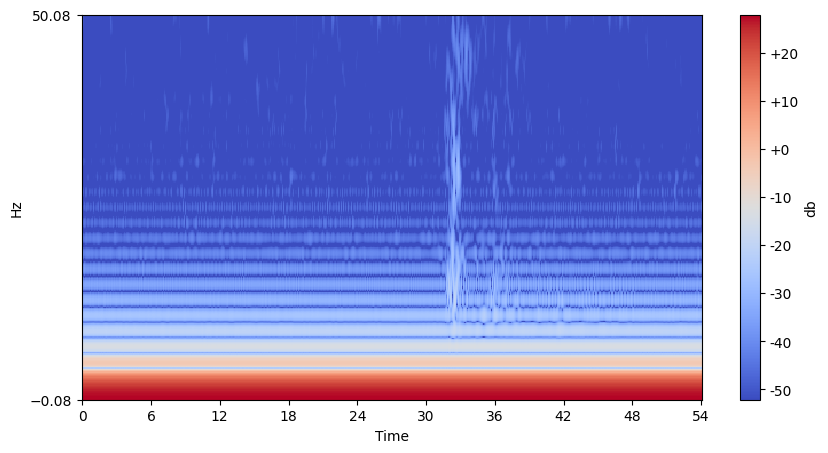

In [31]:
#window = getChunk(signal, i)
sr = 100
total = int((len(signald)-(FRAME_SIZE))/(HOP_SIZE))
S_scale = librosa.stft(signald, n_fft=total,win_length = FRAME_SIZE, hop_length=HOP_SIZE, center=False)

#Y_scale = np.abs(S_scale) ** 2
#Y_log_scale = librosa.power_to_db(Y_scale)

Y_scale = np.abs(S_scale) #** 2
Y_log_scale = librosa.amplitude_to_db(Y_scale)

plotSpectrogram(Y_log_scale, sr, hop_length=HOP_SIZE, y_axis='log')

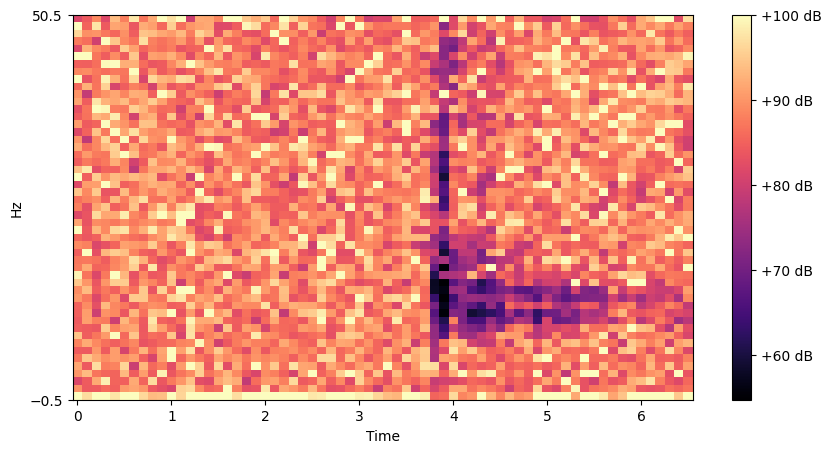

In [64]:
frequencies, times, spectrogram = signal.spectrogram(signald,sr,nfft=100,noverlap=HOP_SIZE, nperseg=100,mode='psd')
plt.figure(figsize=(10, 5))
Y_log_scale = np.abs(librosa.power_to_db(spectrogram))
librosa.display.specshow(Y_log_scale,
                         sr=sr,
                         hop_length=HOP_SIZE,
                         x_axis = 'time',
                         y_axis = 'log')
plt.colorbar(format='%+2.0f dB')

In [68]:
from scipy.fftpack import fft, ifft

def printFFT(window):

    X = fft(window)
    N = len(X)
    n = np.arange(N)
    T = N/sr
    freq = n/T 


    plt.figure(figsize = (8, 4))

    plt.stem(freq, np.log(np.abs(X)), 'b', \
            markerfmt=" ", basefmt="-b")
    plt.xlabel('Freq (Hz)')
    plt.ylabel('FFT Db |X(freq)|')
    #plt.xlim(0, 10)
    plt.ylim(-10, 0)

In [116]:
from scipy.fft import fft, fftfreq

def printFFT2(window):

    # Number of sample points
    N = len(window)
    # sample spacing
    T = 1.0 / 100
    x = np.linspace(0.0, N*T, N, endpoint=False)
    yf = fft(window)
    xf = fftfreq(N, T)[:N//2]

    plt.plot(xf, np.log(np.abs(yf[0:N//2])))
    plt.xlabel('Freq (Hz)')
    plt.ylabel('FFT Db |X(freq)|')
    plt.grid()
    plt.show()

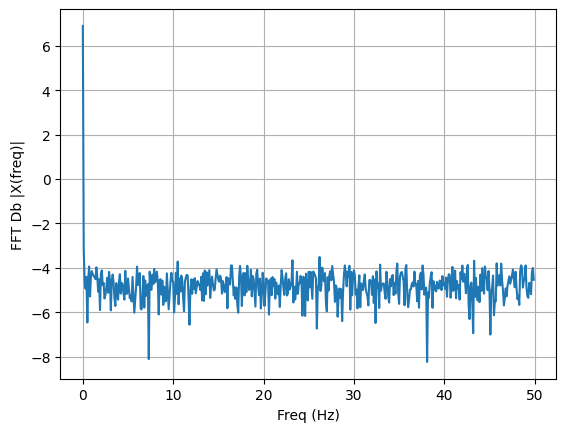

In [133]:
printFFT2(signald[2000:3000])

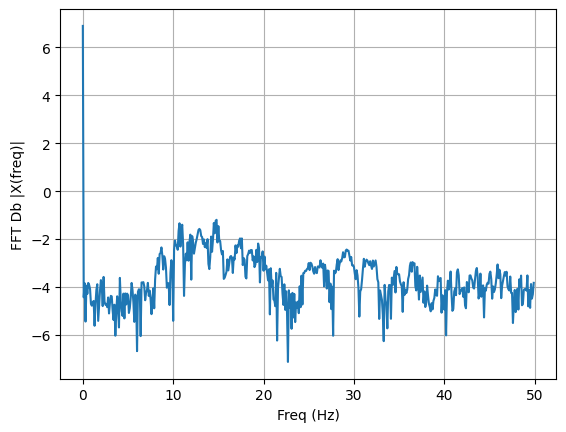

In [134]:
printFFT2(signald[3000:4000])

In [89]:
def printPSD(window):

    f, Pxx_den = signal.welch(window, 100, nperseg=100)

    plt.semilogy(f, Pxx_den)
    plt.ylim([0.5e-10, 0.5e-5])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()

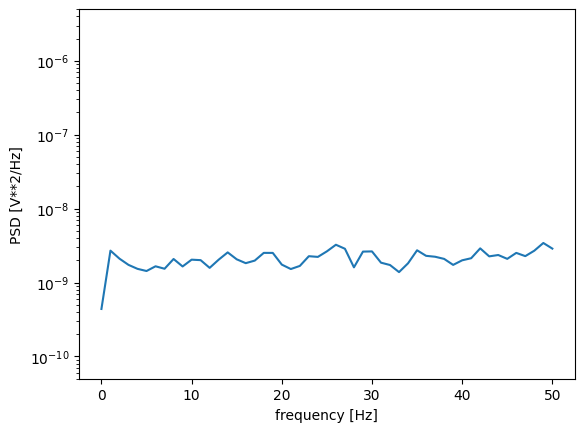

In [90]:
printPSD(signald[2000:3000])

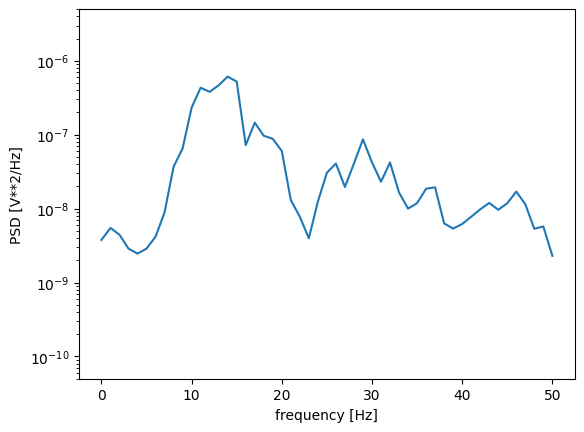

In [91]:
printPSD(signald[3000:4000])